# 오늘은 내가 의사, 폐렴 진단해보기 🩺

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
# 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# x-ray 이미지 사이즈 변수
IMAGE_SIZE = [180,180]

#데이터 경로
ROOT_PATH = os.path.join(os.getenv('HOME'),'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

# 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


* tf.io.gfile.glob : 주어진 패턴과 일치하는 파일 목록을 반환합니다.
* train : test : val = 89% : 10.7% : 0.3%
* val 개수 너무 작음

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


* train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print('훈련데이터 중 정상 폐 이미지 개수:',COUNT_NORMAL)

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print('훈련데이터 중 폐렴 이미지 개수:',COUNT_PNEUMONIA)

훈련데이터 중 정상 폐 이미지 개수: 1072
훈련데이터 중 폐렴 이미지 개수: 3113


* 정상보다 폐렴 이미지 수가 3배 더 많음
* 데이터가 클래스별 imbalance --> 차후 조정

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

* tf.data.Dataset.from_tensor_slices : tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print('훈련 이미지 개수:',TRAIN_IMG_COUNT)

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('검증 이미지 개수:',VAL_IMG_COUNT)

훈련 이미지 개수: 4185
검증 이미지 개수: 1047


* cardinality : 전체 행에 대한 특정 컬럼의 중복 수치를 나타내는 지표
* 중복도가 ‘낮으면’ cardinality 높다고 표현한다.
* 중복도가 ‘높으면’ cardinality 낮다고 표현한다.

In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

* 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높음
* 이미지의 사이즈를 통일 시키고 이미지 사이즈를 줄여보자

* decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. (IMAGE_SIZE = [180,180])

* get_label을 이용해서 라벨 값을 가져옵니다.

In [9]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

* train 데이터 셋과 validation 데이터 셋, test 데이터 셋을 만듭니다. 
* num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 줄 수 있습니다.

In [10]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


* 함수가 잘 작동되는지 확인( resize, 라벨)
* train_ds.take(1) : 하나의 데이터만 가져온다는 의미
* False = 정상

In [11]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


* 테스트 데이터 셋도 만들기
* tf.data.Dataset.list_files : 패턴과 일치하는 모든 파일의 데이터세트를 만든다.

In [12]:
# 좌우반전 augmentation 추가
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

* tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시킴


* shuffle() : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택


* repeat() : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.


* batch() : BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.


* prefetch() : 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
# 3. 데이터 시각화

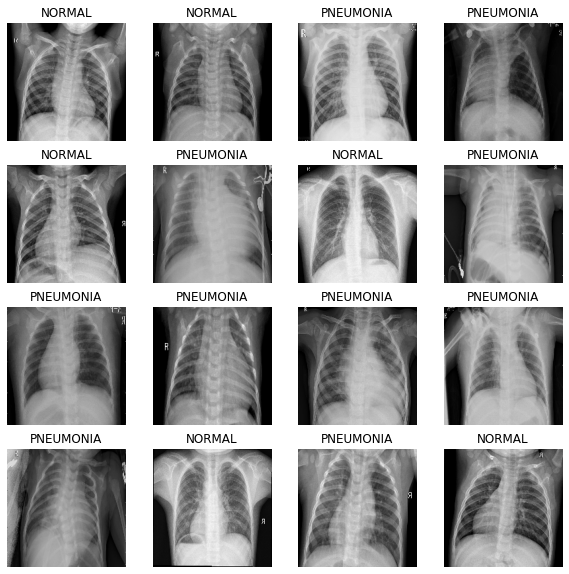

In [13]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링

In [14]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [15]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

* Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

# 5. 데이터 imbalance 처리
* Weight balancing 테크닉 이용
* Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. 

In [16]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


* weight_for_0 : 'Normal' 이미지에 사용할 weight
* weight_for_1 : 'Pneumonia' 이미지에 사용할 weight
* 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

# 6. 모델 훈련

In [17]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [18]:
# with tf.device('/GPU:0'):
#     history = model.fit(
#         train_ds,
#         steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
#         epochs=EPOCHS,
#         validation_data=val_ds,
#         validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
#     )

# 7. 결과 확인과 시각화

In [19]:
# fig, ax = plt.subplots(1, 4, figsize=(20, 3))
# ax = ax.ravel()

# for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
#     ax[i].plot(history.history[met])
#     ax[i].plot(history.history['val_' + met])
#     ax[i].set_title('Model {}'.format(met))
#     ax[i].set_xlabel('epochs')
#     ax[i].set_ylabel(met)
#     ax[i].legend(['train', 'val'])
    
# loss, accuracy, precision, recall = model.evaluate(test_ds)
# print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

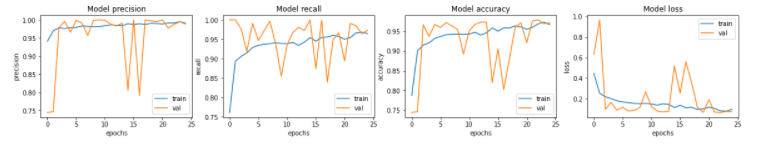
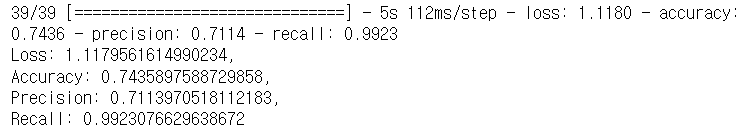

* 모델 훈련 시 자꾸 커널이 죽어서 캡쳐로 대신 했습니다.

# 8. 성능개선

In [20]:
#첫번째 시도 - Batch size 8로 줄이기
BATCH_SIZE = 8

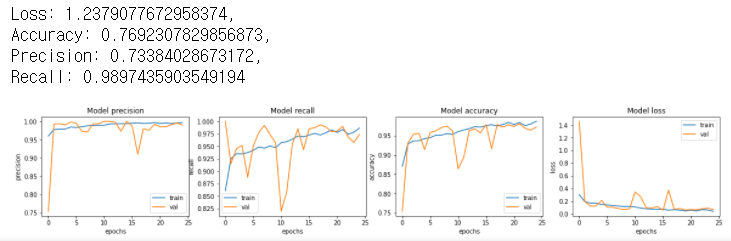

In [22]:
# 두번째 시도 - batch size 늘리기
BATCH_SIZE = 32

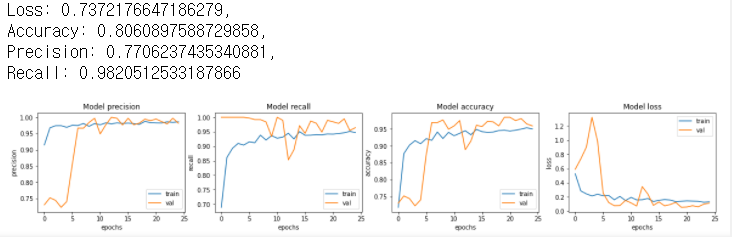

Epoch 1/25
65/65 [==============================] - 30s 277ms/step - loss: 0.6187 - accuracy: 0.6702 - precision: 0.9053 - recall: 0.6200 - val_loss: 0.8131 - val_accuracy: 0.2578 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
65/65 [==============================] - 18s 281ms/step - loss: 0.4227 - accuracy: 0.7808 - precision: 0.9601 - recall: 0.7391 - val_loss: 0.6829 - val_accuracy: 0.7539 - val_precision: 0.7539 - val_recall: 1.0000
Epoch 3/25
65/65 [==============================] - 18s 285ms/step - loss: 0.3495 - accuracy: 0.8317 - precision: 0.9575 - recall: 0.8045 - val_loss: 0.5615 - val_accuracy: 0.7578 - val_precision: 0.7578 - val_recall: 1.0000
Epoch 4/25
65/65 [==============================] - 19s 300ms/step - loss: 0.2711 - accuracy: 0.8712 - precision: 0.9779 - recall: 0.8478 - val_loss: 0.6643 - val_accuracy: 0.6836 - val_precision: 0.6836 - val_recall: 1.0000
Epoch 5/25
65/65 [==============================] - 21s 320ms/step - loss: 0.2965 - accuracy

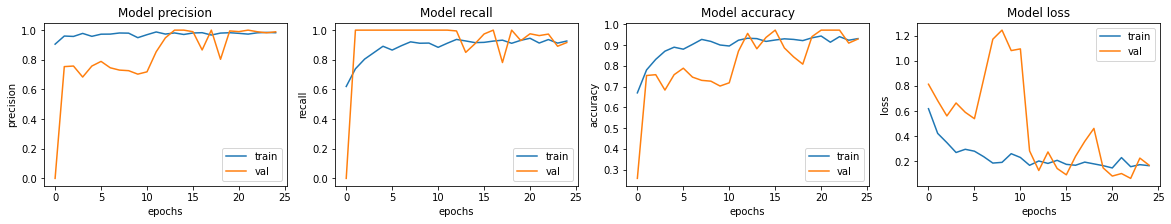

In [23]:
# 세번째 시도 - batch size 64로 늘리기
BATCH_SIZE = 64

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

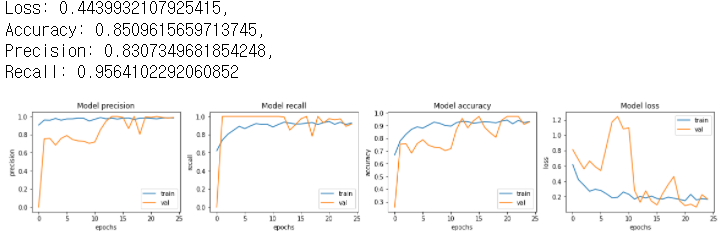

우와!! 성공~~😎😎😎

# 회고

좌우반전 augmentation 을 추가하였고 batch size를 늘려서 루브릭 기준을 만족시킬 수 있었다.augmentation을 적용하여 훈련 세트의 다양성을 증가시킬 수 있었고 의료영상에서는 신중하게 적용해야한다는 것도 배웠다. 아직은 데이터가 많지 않아서 의사만큼의 정확도를 낼 수 없지만 나중에는 인간을 넘어서 정확도를 예측하겠지? 
